In [1]:
import subprocess, os
import pandas as pd
from Protein import *
import numpy as np
from scipy.stats import hypergeom as hg
import matplotlib.pyplot as plt
import random
from utils import*
from Subcellular import *

ModuleNotFoundError: No module named 'Protein'

In [19]:
class RunNerve():
    """Class to store nerve parameters and run NERVE program"""

    def __init__(self):
        """Initiate arguments and program path"""
        
        self.args = {
            'annotation': True,
            'autoimmunity': True,
            'topology': 'tmhmm',
            'e_value': 1e-10,
            'minlength': 9,
            'mismatch': 1,
            'mouse': True,
            'mouse_peptides_sum_limit': .15,
            'proteome1': None,
            'proteome2': None, 
            'padlimit': 0.80,
            'razor': True,
            'antigenlimit': 0.80,
            'loclimit': 0.60, 
            'min_loop_length': 9,
            'select': True, 
            'substitution': 3,
            'transmem_doms_limit': 0,
            'antigen': False,
            'working_dir': './', 
            'NERVE_dir': './',
            'iFeature_dir': './iFeature',
            'DeepFri_dir': './DeepFRI',
            'epitopes': False,
            
            
                     }
        self.program = "./nerve.py"

    def print_args(self):
        print(f'Arguments are:\n{self.args}')
        print(f'eNERVE executable path is:\n{self.program}')
    
    def run(self):
        """Pass commands to line
        program: command/program to run
        args: arguments"""
        
        program = self.program
        args = self.args
        for key in args:
            args[key] = str(args[key])
        
        args_list = []
        for item in args.items():
            args_list.append(f'--{item[0]}')
            args_list.append(item[1])
        cmd = ['python3'] + [program] + args_list
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        output, error = process.communicate()
        return output, error

In [96]:
#class Localization:
        #"""class to store and handle protein subcellular localizations"""
        #def __init__(self, localization, reliability):
            #self.reliability_out = model.predict_proba(data)[0][0]
           # self.localization = 'out' if p.reliability_out >= loclimit else 'in'
            #self.localization = str(localization)
            #self.reliability_out = float(localization_score)

def protein_loader(proteome):
    
    if type(proteome) != pd.DataFrame:
        df = pd.read_csv(proteome)
    else:
        df = proteome
    df = df.astype(object).where(pd.notnull(df),None)
    list_of_proteins = []
    for index, row in df.iterrows():
        protein = Protein(row['id'], row['sequence'])
        protein.accession = row['accession']
        protein.length = row['length']
        protein.transmembrane_doms = 0 if row['transmembrane_doms'] == None else row['transmembrane_doms']
        protein.localization = row['localization']
        protein.localization_score = row['localization_score'] 
        protein.p_ad = row['adhesin_probability']
        protein.conservation_score = row['conservation_score']
        protein.shared_human_peps = 0 if row['shared_human_peps'] == None else row['shared_human_peps']
        protein.shared_mouse_peps = 0 if row['shared_mouse_peps'] == None else row['shared_mouse_peps']
        protein.shared_conserv_proteome_peps = 0 if row['shared_conserved_proteome_peps'] == None else row['shared_conserved_proteome_peps']
        protein.sapiens_peptides_sum = 0 if row['human_peptides_sum'] == None else row['human_peptides_sum']
        protein.mouse_peptides_sum = 0 if row['mouse_peptides_sum'] == None else row['mouse_peptides_sum']
        protein.annotations = row['annotations']
        protein.list_of_peptides_from_comparison_with_mhcpep_sapiens = [] if \
        row['list_of_peptides_from_comparison_with_mhcpep_sapiens'] == None else \
        [peptide for peptide in range(len(row['list_of_peptides_from_comparison_with_mhcpep_sapiens']))]
        protein.list_of_peptides_from_comparison_with_mhcpep_mouse = [] if \
        row['list_of_peptides_from_comparison_with_mhcpep_mouse'] == None else \
        [peptide for peptide in range(len(row['list_of_peptides_from_comparison_with_mhcpep_mouse']))]
        protein.original_sequence_if_razor = row['original_sequence_if_razor']
        protein.tmhmm_seq = row['tmhmm_seq']
        list_of_proteins.append(protein)
    return list_of_proteins

def select(list_of_proteins, transmem_doms_limit,
           padlimit, mouse, mouse_peptides_sum_limit, loclimit, razor)->list:
    """Selects suitable candidate proteins for vaccine production"""
        
    final_list = []
    
    for protein in list_of_proteins:
        # exclude internal proteins with low P_AD or P_ANTIGEN
        #if protein.localization == "in": continue
        if protein.localization == 'in' and protein.p_ad < padlimit: continue
        
        if razor == 'True':
            if (protein.transmembrane_doms >= transmem_doms_limit) and (protein.original_sequence_if_razor is None): continue
        if razor == 'False':
            if protein.transmembrane_doms >= transmem_doms_limit: continue
            
       
        
        #if (p.transmembrane_doms >= transmem_doms_limit) and (p.original_sequence_if_razor is None): continue
        #if autoimmunity == "True":
        if protein.sapiens_peptides_sum > .15: continue
        if len(protein.list_of_peptides_from_comparison_with_mhcpep_sapiens) >= 1: continue
        if mouse == "True":
            if protein.mouse_peptides_sum > mouse_peptides_sum_limit: continue
            if len(protein.list_of_peptides_from_comparison_with_mhcpep_mouse) >= 1: continue

        

        final_list.append(protein)
    return final_list



# PREPARE FILES (ANTIGENS) INTO A FASTA FILE

In [4]:
# prepare files for tuning
def to_fasta(df, outfile):
    """Converts pandas cells to fasta"""
    
    outfile = open(outfile, 'w')
    for index, row in df.iterrows():
        outfile.write('>' + row['Entry'] + '_' + row['Organism'] + '\n'
                      + row['Sequence'].replace(" ", "") + '\n')
    outfile.close()

In [5]:
df = pd.read_excel('./antigen_def.xlsx')

to_fasta(df, './tuning.fasta')    #generate fasta file into current dir


# precalculate antigen scores

In [6]:
nerve_run = RunNerve()
nerve_run.args['proteome1'] = './tuning.fasta'
nerve_run.args.pop('proteome2')
nerve_run.args['select'] = False        #with select module off we only calculate protein scores
nerve_run.args['working_dir'] = './wd'
out, err = nerve_run.run()

# Test on proteomes

In [99]:
nerve_tuning = pd.read_excel('./antigen_def.xlsx')
nerve_tuning = nerve_tuning[nerve_tuning != 1]
tuning_proteomes  = list(nerve_tuning['Proteomes'].unique())
print(f'Proteomes: {len(tuning_proteomes)}, antigens: {len(nerve_tuning)}')

Proteomes: 14, antigens: 109


In [100]:
tuning_proteomes   #Proteomes to download

['UP000001450',
 'UP000024404',
 'UP000008333',
 'UP000008854',
 'UP000000559',
 'UP000001926',
 'UP000002530',
 'UP000008524',
 'UP000002296',
 'UP000000542',
 'UP000010091',
 'UP000074855',
 'UP000001435',
 'UP000007062']

In [23]:
def tuning(padlimit, loclimit, proteomes):
    """Runs NERVE tuning"""
    
    outdic = {'n': {}}
    
   
    '''
    eu = RunNerve()
    eu.args['proteome1'] = './tuning/eu.fasta'
    eu.args.pop('proteome2')
    working_dir = f'./tuning/eu_padlimit_{str(padlimit)}_loclimit_{str(loclimit)}'
    eu.args['working_dir'] = working_dir
    out, err = eu.run()
    df_vaccines = pd.read_csv(os.path.join(working_dir, 'eu_vaccine_candidates.csv'))
    df_non_vaccines = pd.read_csv(os.path.join(working_dir, 'eu_discarded_proteins.csv'))    
    outdic['n']['eu_recall'] = len(df_vaccines) / (len(df_vaccines) + len(df_non_vaccines))
    '''
    
    
    for proteome in proteomes:
        prot_run = RunNerve()
        prot_run.args['proteome1'] = proteome
        #prot_run.args['gram'] = 'n'
        prot_run.args.pop('proteome2')
        working_dir = f'./tuning/{str(proteome)}_padlimit_{str(padlimit)}_loclimit_{str(loclimit)}'
        prot_run.args['working_dir'] = working_dir
        out, err = prot_run.run()
        df_vaccines = pd.read_csv(os.path.join(working_dir, 'eu_vaccine_candidates.csv'))
        df_non_vaccines = pd.read_csv(os.path.join(working_dir, 'discarded_proteins.csv'))    
        outdic['n'][proteome] = len(df_vaccines) / (len(df_vaccines) + len(df_non_vaccines))
     
    
    
    return outdic

In [13]:
#outdic = tuning(0.5 padlimit, 0.5 loclimit, ['UP000000419', 'UP000002676', 'UP000000540'], ['UP000001978', 'UP000031961', 'UP000001584'])

outdic = tuning(0.5, 0.5, ['UP000001450', 'UP000024404', 'UP000008333','UP000008854', 'UP000000559', 'UP000001926',
                          'UP000002530', 'UP000008524', 'UP000002296', 'UP000000542', 'UP000010091', 'UP000074855',
                          'UP000001435', 'UP000007062'])      #5-6hrs*14 proteomes = 70/84 hrs = 2.9/3.5 days

# run finetuning

In [24]:
len(pd.read_excel('./antigen_def.xlsx'))

109

In [25]:
nerve_tuning = pd.read_excel('./antigen_def.xlsx')
nerve_tuning = nerve_tuning[(nerve_tuning != 1)]
tuning_proteomes  = list(nerve_tuning['Proteomes'].unique())
print(f'Proteomes: {len(tuning_proteomes)}, antigens: {len(nerve_tuning)}')

Proteomes: 14, antigens: 109


In [48]:
cd tuning

[Errno 2] No such file or directory: 'tuning'
/home/matteo/Desktop/eNERVE/tuning


In [97]:
tuning_proteomes = ['UP000001450']

In [106]:
# run parameter grid search and collect accuracy, coverage, p-value
CONDITIONS = [[i/100, s/100] for i in range(50, 100, 5) for s in range(50, 100, 5)]

# read in precomputaded nerve predictions on known antigens
nerve_tuning_results = pd.read_csv('./eu_vaccine_candidates.csv')

outlist = []
for condition in CONDITIONS:
    number_of_selected_proteins = 0
    number_of_total_proteins = 0
    loclimit, padlimit = condition
    
    # evaluate for known antigens
    list_of_known_antigens = protein_loader(nerve_tuning_results)
    list_of_known_antigens_seqs = [protein.sequence for protein in list_of_known_antigens]
    selected_antigens = select(list_of_proteins = list_of_known_antigens,
                        transmem_doms_limit = 0,
                        padlimit = padlimit, mouse = "True",
                        mouse_peptides_sum_limit = .15,
                        loclimit = loclimit,
                              razor = "True")
                        #antigen = "False",
                        #antigenlimit = 0,
                        #autoimmunity = True,
                        #annotation = True)
    # evaluate for proteomes
    for proteome in tuning_proteomes:
        path = os.path.join('./tuning/', proteome, 'eu_vaccine_candidates.csv')
        list_of_proteins = protein_loader(path)
        for protein in list_of_proteins:
            if protein.sequence in list_of_known_antigens_seqs:
                list_of_proteins.remove(protein)
        selected_proteins = select(list_of_proteins = list_of_proteins,
                            transmem_doms_limit = 3,
                            padlimit = padlimit, mouse = "True",
                            mouse_peptides_sum_limit = .15,
                            loclimit = loclimit,
                                  razor = "True")
                                  #autoimmunity = True, 
                                  #annotation = True)
        # populate values
        number_of_selected_proteins += len(selected_proteins)
        number_of_total_proteins += len(list_of_proteins)
        
    number_of_selected_proteins = number_of_selected_proteins + len(selected_antigens)
    number_of_total_proteins = number_of_total_proteins + len(list_of_known_antigens)
    
    expected_bpas = round((len(list_of_known_antigens) * number_of_selected_proteins) / number_of_total_proteins, 2)
    values = [loclimit, padlimit, round((len(selected_antigens) / len(list_of_known_antigens))*100, 2),
                    round((number_of_selected_proteins / number_of_total_proteins)*100, 2),  
                   expected_bpas, round(len(selected_antigens)/expected_bpas, 2), 
                    hg.sf(len(selected_antigens)-1, 
                          number_of_total_proteins, len(list_of_known_antigens), number_of_selected_proteins)]
    print(values)
    outlist.append(values)
        
        

[0.5, 0.5, 64.08, 99.64, 102.63, 0.64, 1.0]
[0.5, 0.55, 64.08, 99.64, 102.63, 0.64, 1.0]
[0.5, 0.6, 63.11, 99.64, 102.62, 0.63, 1.0]
[0.5, 0.65, 62.14, 99.63, 102.62, 0.62, 1.0]
[0.5, 0.7, 62.14, 99.63, 102.62, 0.62, 1.0]
[0.5, 0.75, 60.19, 99.62, 102.61, 0.6, 1.0]
[0.5, 0.8, 56.31, 99.6, 102.59, 0.57, 1.0]
[0.5, 0.85, 56.31, 99.6, 102.59, 0.57, 1.0]
[0.5, 0.9, 54.37, 99.59, 102.58, 0.55, 1.0]
[0.5, 0.95, 53.4, 99.59, 102.57, 0.54, 1.0]
[0.55, 0.5, 64.08, 99.64, 102.63, 0.64, 1.0]
[0.55, 0.55, 64.08, 99.64, 102.63, 0.64, 1.0]
[0.55, 0.6, 63.11, 99.64, 102.62, 0.63, 1.0]
[0.55, 0.65, 62.14, 99.63, 102.62, 0.62, 1.0]
[0.55, 0.7, 62.14, 99.63, 102.62, 0.62, 1.0]
[0.55, 0.75, 60.19, 99.62, 102.61, 0.6, 1.0]
[0.55, 0.8, 56.31, 99.6, 102.59, 0.57, 1.0]
[0.55, 0.85, 56.31, 99.6, 102.59, 0.57, 1.0]
[0.55, 0.9, 54.37, 99.59, 102.58, 0.55, 1.0]
[0.55, 0.95, 53.4, 99.59, 102.57, 0.54, 1.0]
[0.6, 0.5, 64.08, 99.64, 102.63, 0.64, 1.0]
[0.6, 0.55, 64.08, 99.64, 102.63, 0.64, 1.0]
[0.6, 0.6, 63.11, 9

In [102]:
df = pd.DataFrame(outlist, columns = ['loclimit', 'padlimit', 'recall (%)',
                                'coverage (%)', 'expected_bpas', 'fold-enrichment', 'p-value'])
df

,loclimit,padlimit,recall (%),coverage (%),expected_bpas,fold-enrichment,p-value
0,0.50,0.50,64.08,99.82,102.81,0.64,1.0
1,0.50,0.55,64.08,99.82,102.81,0.64,1.0
2,0.50,0.60,63.11,99.81,102.81,0.63,1.0
3,0.50,0.65,62.14,99.81,102.80,0.62,1.0
4,0.50,0.70,62.14,99.81,102.80,0.62,1.0
...,...,...,...,...,...,...,...
95,0.95,0.75,60.19,99.80,102.79,0.60,1.0
96,0.95,0.80,56.31,99.78,102.77,0.56,1.0
97,0.95,0.85,56.31,99.78,102.77,0.56,1.0
98,0.95,0.90,54.37,99.77,102.76,0.54,1.0


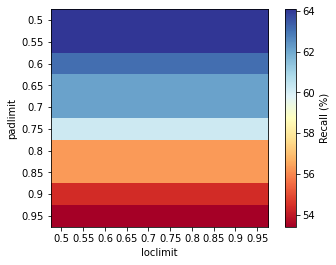

In [103]:
 

new_column = df.loclimit.unique()
new_index = df.padlimit.unique()
plot_outlist = []
for index in new_index:
    tmp_row = []
    for column in new_column:
        tmp_accuracy = df[(df.padlimit == index) & (df.loclimit == column)]['recall (%)'].to_list()[0]
        tmp_row.append(tmp_accuracy)
    plot_outlist.append(tmp_row)
plot_df = pd.DataFrame(plot_outlist, index=new_index, columns=new_column)

plt.imshow(plot_df, cmap ="RdYlBu", )
plt.colorbar(label='Recall (%)')
plt.xticks(range(len(plot_df)), plot_df.columns)
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xlabel('loclimit')
plt.ylabel('padlimit')
plt.show()



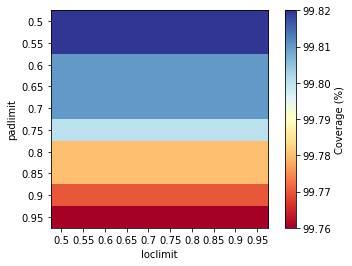

In [104]:
new_column = df.loclimit.unique()
new_index = df.padlimit.unique()
plot_outlist = []
for index in new_index:
    tmp_row = []
    for column in new_column:
        tmp_accuracy = df[(df.padlimit == index) & (df.loclimit == column)]['coverage (%)'].to_list()[0]
        tmp_row.append(tmp_accuracy)
    plot_outlist.append(tmp_row)
plot_df = pd.DataFrame(plot_outlist, index=new_index, columns=new_column)

plt.imshow(plot_df, cmap ="RdYlBu", )
plt.colorbar(label='Coverage (%)')
plt.xticks(range(len(plot_df)), plot_df.columns)
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xlabel('loclimit')
plt.ylabel('padlimit')
plt.show()

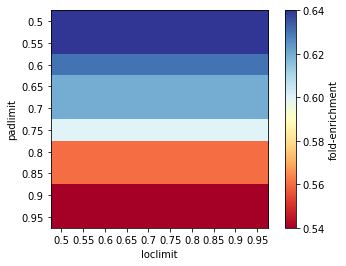

In [105]:
new_column = df.loclimit.unique()
new_index = df.padlimit.unique()
plot_outlist = []
for index in new_index:
    tmp_row = []
    for column in new_column:
        tmp_accuracy = df[(df.padlimit == index) & (df.loclimit == column)]['fold-enrichment'].to_list()[0]
        tmp_row.append(tmp_accuracy)
    plot_outlist.append(tmp_row)
plot_df = pd.DataFrame(plot_outlist, index=new_index, columns=new_column)

plt.imshow(plot_df, cmap ="RdYlBu", )
plt.colorbar(label='fold-enrichment')# format='%.0e')
plt.xticks(range(len(plot_df)), plot_df.columns)
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xlabel('loclimit')
plt.ylabel('padlimit')
plt.show()

In [ ]:
#df.to_csv('./tuning/NERVE_2_tuning.csv', index=False)